## Importing libraries

In [6]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import time
import fastparquet

pd.set_option('display.max_rows', None)

## The Data Frame
#### The Netflix Prize dataset, released in 2006, is a renowned collection of movie ratings from Netflix users, aimed at improving recommendation algorithms. It comprises millions of ratings across 17,770 movies and 480,189 users, stored into 4 text files. Data is in text format, featuring user IDs, movie IDs, ratings, and timestamps. The challenge focused on minimizing their recommender system's original Root Mean Squared Error (RMSE) of about 0.95.

## Reading files into a dataframe

In [5]:
# Starts a time counter
start_time = time.time()

# Creates an empty dataframe
movies = pd.DataFrame()

# Gets current work directory
cwd = os.getcwd()

# Gathers files' names.
filenames = glob.glob(cwd + "\*.txt")

# Starts a counter at 0
counter = 0

# For each file name in the list of file names
for filename in filenames:
    
    # If combined is part of a given file's name
    if 'combined' in filename:

        # Creates an empty list to store lines from the file
        lines = []

        # Opens file
        with open(filename, 'r') as file:

            # Reads the file line by line
            for line in file:

                # If a colon is present on a given line
                if ':' in line:

                    # Strip line and store movie id
                    movie_id = line.strip()[:-1]

                # If there is no colon present on line
                else:

                    # Strips line, combines with movie id and stores it into a variable
                    # Then adds variable to list of lines
                    new_line = line.strip() + ',' + movie_id
                    lines.append(new_line.strip().split(','))

        # Creates a temporary dataframe using the list of lines
        temp_df = pd.DataFrame(data = lines, columns = ['CustomerID', 'Rating', 'RatingDate', 'MovieID'])
        
        # Concatenates temporary and permanent dataframe
        movies = pd.concat([movies, temp_df])
        
    # Updates counter and prints it.
    # This was done to keep track of the script's progress due to how long it takes to execute.
    # This will be done many times throughout this notebook
    counter += 1
    print(f'Finished file: {counter}')
        
# Stores time for when script finishes running
end_time = time.time()

# Calculates and prints time spent running script
time_elapsed = end_time - start_time
print(f'Time elapsed: {time_elapsed}')

# Looking at it
movies.head()

Finished file: 1
Finished file: 2
Finished file: 3
Finished file: 4
Time elapsed: 837.4385068416595


,CustomerID,Rating,RatingDate,MovieID
0,1488844,3,2005-09-06,1
1,822109,5,2005-05-13,1
2,885013,4,2005-10-19,1
3,30878,4,2005-12-26,1
4,823519,3,2004-05-03,1


## Writting dataframe to a parquet file, which should be lighter to load
#### Reading the file is much faster than re-building the dataframe. This will also be done multiple times throughout this notebook.

In [11]:
start_time = time.time()

movies.to_parquet('Movies_df.parquet', index = False)

end_time = time.time()
time_elapsed = end_time - start_time
print(f'Time writting: {time_elapsed}')

Time writting: 562.1447179317474


## Reading file, which takes a fraction of the time to read all files and build the dataframe.

In [2]:
start_time = time.time()

movies = pd.read_parquet('Movies_df.parquet')

end_time = time.time()
time_elapsed = end_time - start_time
print(f'Time reading: {time_elapsed}')

# Looking at it
movies.head()

Time reading: 32.67752146720886


,CustomerID,Rating,RatingDate,MovieID
0,1488844,3,2005-09-06,1
1,822109,5,2005-05-13,1
2,885013,4,2005-10-19,1
3,30878,4,2005-12-26,1
4,823519,3,2004-05-03,1


## Checking how many rows there are on the dataframe
#### Each row contains a rating from a customer

In [49]:
len(movies)

100480507

## Casting to lighter data types to spare RAM memory during processing

In [28]:
# Casting columns to lighter data types, which should help with memory usage
# Casting Ratings to integer so that last non zero value of a given column can be found
# This will assist in keeping only most current reviews

start_time = time.time()

movies['CustomerID'] = movies['CustomerID'].astype(bytes)
movies['Rating'] = movies['Rating'].astype(np.uint8)
movies['RatingDate'] = pd.to_datetime(movies['RatingDate'], format = '%Y-%m-%d')
movies['MovieID'] = movies['MovieID'].astype(np.uint8)

end_time = time.time()
time_elapsed = end_time - start_time
print(f'Time elapsed: {time_elapsed}')

movies.dtypes

Time elapsed: 70.71892738342285


CustomerID               |S7
Rating                 uint8
RatingDate    datetime64[ns]
MovieID                uint8
dtype: object

## Storing classes in a list

In [35]:
classes = ['1', '2', '3', '4', '5']

## Creating function to get frequency of each class

In [40]:
def get_values(df):
    
    start_time = time.time()

    one_star = len(df[df['Rating'] == 1])
    two_stars = len(df[df['Rating'] == 2])
    three_stars = len(df[df['Rating'] == 3])
    four_stars = len(df[df['Rating'] == 4])
    five_stars = len(df[df['Rating'] == 5])
    remaining = len(df) - one_star - two_stars - three_stars - four_stars - five_stars

    end_time = time.time()
    time_elapsed = end_time - start_time
    print(f'Time elapsed: {time_elapsed}')
    
    return one_star, two_stars, three_stars, four_stars, five_stars, remaining

## Calling function

In [32]:
one_star, two_stars, three_stars, four_stars, five_stars, remaining = get_values(movies)

Time elapsed: 7.53607702255249


## Making sure nothing was left behind

In [33]:
remaining

0

## Adding all class frequencies to a list

In [34]:
values = [one_star, two_stars, three_stars, four_stars, five_stars]

## Creating function to plot a bar chart

In [41]:
def plot_bar_chart(classes, values):
    
    # Creating a figure
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (3, 3), dpi = 200)

    # Create bar chart on the axes
    bars = ax.bar(classes, values)

    # Add labels and title
    ax.set_title('Distribution of Ratings')

    # Remove y-axis ticks and labels
    ax.yaxis.set_ticks([])
    ax.set_yticklabels([])

    # Show the plot
    plt.show()

## Calling function to plot bar chart and look at the distrbution of ratings

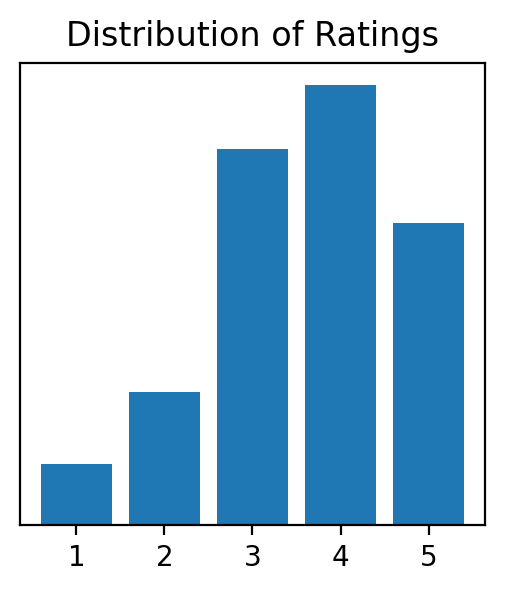

In [42]:
plot_bar_chart(classes, values)

## Splitting dataframe into predictors and target

In [37]:
start_time = time.time()

x = movies[['RatingDate', 'CustomerID', 'MovieID']]
y = movies['Rating']

end_time = time.time()
time_elapsed = end_time - start_time
print(f'Time elapsed: {time_elapsed}')

Time elapsed: 63.62835454940796


## Using scikit learn's train_test_split to create a sample of the dataframe.
#### The laptop on which this script was executed has 32GB of RAM and it was still not nearly enough to process the entire dataframe, so the recommender system will have to be built off a 10% sample, which proved itself still dificult to process.

In [38]:
start_time = time.time()

# Using train_test_split stratified sampling to create a sample seeing that working on the entire dataset is computationally
# expensive.
x_sample, x_remaining, y_sample, y_remaining = train_test_split(x, y, test_size = 0.9, stratify = y, random_state = 42)

end_time = time.time()
time_elapsed = end_time - start_time
print(f'Time elapsed: {time_elapsed}')

Time elapsed: 74.10764074325562


## Putting target back in the dataframe

In [50]:
x_sample['Rating'] = y_sample
movies_sample = x_sample

movies_sample.reset_index(drop=True, inplace=True)

movies_sample.head()

,RatingDate,CustomerID,MovieID,Rating
0,2005-11-23,b'1624455',249,3.0
1,2005-02-21,b'1788360',90,NaN
2,2005-04-04,b'359726',217,NaN
3,2004-06-28,b'1346159',232,NaN
4,2005-11-15,b'1084626',44,NaN


## Checking number of rows to make sure only 10% of the original dataframe is being used

In [51]:
print(len(movies_sample))

10048050


## Calling function again to investigate whether sample distribution is indeed the same as the original dataframe's

In [52]:
one_star, two_stars, three_stars, four_stars, five_stars, remaining = get_values(movies_sample)

Time elapsed: 0.3246927261352539


In [44]:
remaining

0

In [53]:
new_values = [one_star, two_stars, three_stars, four_stars, five_stars]

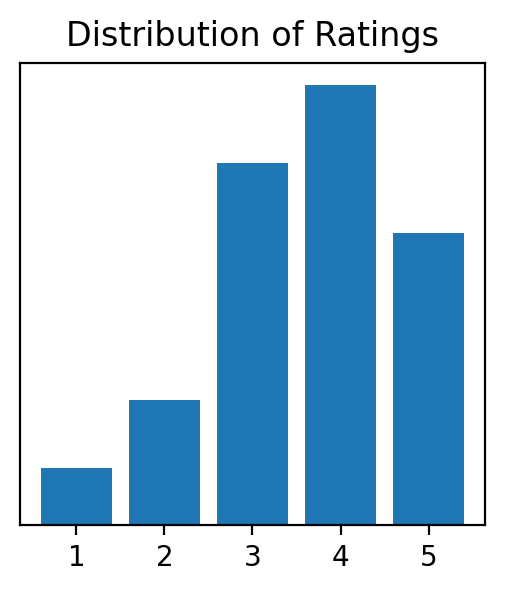

In [54]:
plot_bar_chart(classes, new_values)

## Using get_dummies function to create columns for each movie ID
#### Now there is a column for each movie, filled with zeros and ones, where the latter means a given movie received a rating on the date which corresponds to that row.

In [55]:
start_time = time.time()

dummies = pd.get_dummies(np.array(movies_sample['MovieID'], dtype = np.uint8), dtype = np.uint8)

end_time = time.time()
time_elapsed = end_time - start_time
print(f'Time elapsed: {time_elapsed}')

dummies.head()

Time elapsed: 15.429225206375122


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Adding columns back to dataframe.
#### This can only be done like this because both dataframes match each other exactly, i.e have the exact same rows on the exact same index positions.

In [56]:
start_time = time.time()

dummies['CustomerID'] = movies['CustomerID']
dummies['Rating'] = movies['Rating']
dummies['RatingDate'] = movies['RatingDate']

end_time = time.time()
time_elapsed = end_time - start_time
print(f'Time elapsed: {time_elapsed}')

dummies.head()

Time elapsed: 1.3139419555664062


,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,CustomerID,Rating,RatingDate
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,b'1488844',3,2005-09-06
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,b'822109',5,2005-05-13
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,b'885013',4,2005-10-19
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,b'30878',4,2005-12-26
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,b'823519',3,2004-05-03


## Getting all movie IDs into a list so that columns can be re-arranged

In [57]:
start_time = time.time()

# Adds column names to a list and creates empty list to store remaining column names
first_cols = ['RatingDate', 'CustomerID', 'Rating']
remaining_cols = []

# For each column in the list of columns for the dataframe
for col in dummies.columns:
    
    # If a given column is not one of the first columns
    if col not in first_cols:
        
        # Add column name to list of remaining columns
        remaining_cols.append(col)
        
end_time = time.time()
time_elapsed = end_time - start_time
print(f'Time elapsed: {time_elapsed}')
        
# Looking at it
remaining_cols[:5]

Time elapsed: 0.003999471664428711


[0, 1, 2, 3, 4]

## Re-arranging columns

In [58]:
start_time = time.time()

# Creates a list of column names in the desired order
cols = first_cols + remaining_cols

# Re-arranges columns
dummies = dummies.reindex(cols, axis = 1)

end_time = time.time()
time_elapsed = end_time - start_time
print(f'Time elapsed: {time_elapsed}')

# Looking at it
dummies.head()

Time elapsed: 4.359864711761475


,RatingDate,CustomerID,Rating,0,1,2,3,4,5,6,...,246,247,248,249,250,251,252,253,254,255
0,2005-09-06,b'1488844',3,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,2005-05-13,b'822109',5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2005-10-19,b'885013',4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2005-12-26,b'30878',4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2004-05-03,b'823519',3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Passing ratings to movie ID columns

In [60]:
start_time = time.time()

# For each of the movie ID column names in the list of columns 
for colname in dummies.columns[3:]:
    
    # Pass value from the Ratings column to a given column where there is a one, otherwise keep value as is
    dummies[colname] = np.where(dummies[colname] != 0, dummies['Rating'], dummies[colname])
    
end_time = time.time()
time_elapsed = end_time - start_time
print(f'Time elapsed: {time_elapsed}')
    
dummies.head()

Time elapsed: 4.841289043426514


,RatingDate,CustomerID,Rating,0,1,2,3,4,5,6,...,246,247,248,249,250,251,252,253,254,255
0,2005-09-06,b'1488844',3,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0
1,2005-05-13,b'822109',5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2005-10-19,b'885013',4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2005-12-26,b'30878',4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2004-05-03,b'823519',3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Dropping Rating column

In [61]:
start_time = time.time()

dummies.drop(columns = 'Rating', inplace = True)

end_time = time.time()
time_elapsed = end_time - start_time
print(f'Time elapsed: {time_elapsed}')

dummies.head()

Time elapsed: 19.495550632476807


,RatingDate,CustomerID,0,1,2,3,4,5,6,7,...,246,247,248,249,250,251,252,253,254,255
0,2005-09-06,b'1488844',0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0
1,2005-05-13,b'822109',0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2005-10-19,b'885013',0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2005-12-26,b'30878',0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2004-05-03,b'823519',0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Taking steps to consolidate multiple customer entries in one

In [62]:
start_time = time.time()

# Gets unique customer ids and stores it in a list
unique_customer_ids = dummies['CustomerID'].unique().tolist()

# Creates an empty list to store "temporary dataframes"(most current ratings for each customer)
series_list = []

end_time = time.time()
time_elapsed = end_time - start_time
print(f'Time elapsed: {time_elapsed}')

dummies.head()

Time elapsed: 2.8936173915863037


,RatingDate,CustomerID,0,1,2,3,4,5,6,7,...,246,247,248,249,250,251,252,253,254,255
0,2005-09-06,b'1488844',0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0
1,2005-05-13,b'822109',0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2005-10-19,b'885013',0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2005-12-26,b'30878',0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2004-05-03,b'823519',0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Checking how many rows versus how many unique customer ids there are in the dataframe
#### Once all ratings are consolidated, number of rows should match the number of unique customer ids.

In [63]:
print(dummies['CustomerID'].nunique())
print(len(dummies['CustomerID']))

448203
10048050


## Sorting dataframe. At first, due to memory leakage, this was done in batches, which causes the processing time to increase by A LOT. Once a sample was taken, it went back to being performed all at once, which saves up an enormous amount of time.

In [65]:
# Sorting the entire dataframe at once instead of by chunks uses more RAM, but makes the next step faster, and sampling the
# original dataframe allowed it to be sorted at once.
dummies.sort_values(by = 'RatingDate', ignore_index = True, inplace = True)

## Consolidating all customer entries into one, keeping only most recent ratings
#### Having sorted entire dataframe at once, rather than in batches to save RAM, caused the process below to be about 10 times faster. Consolidating customer id entries brought the length of the dataframe to about 4.5% of what it used to be, making the dataframe much more manageable.

In [2]:
# Start time and counter being created to keep track of the execution time.
total_start_time = time.time()

# Storing number of unique customer ids.
total_unique_customer_ids = len(unique_customer_ids)

# For each customer id
for unique_customer_id in unique_customer_ids:
    
    # Create a temporary dataframe for a given unique customer id
    temp_df = dummies[dummies['CustomerID'] == unique_customer_id]

    # Reset index
    temp_df.reset_index(drop = True, inplace = True)

    # For each column of the temporary dataframe
    for col_idx in range(len(temp_df.columns)):
        
        # .values returns the values of the series as a list
        # np.nonzero() on a list will return a tuple where the first position is an array and the second position seems to be empty
        # In that array, the first position contains a list of indices of all non zero values in the list, and the second position is
        # the data type for the items in the list.
        # [0] will return just the array
        # [-1:] will return the same array, except that with only the last value of the list in the first position (last non zero value)
        # The second [0] returns just the last non zero value in the array/column.

        try:

            current_rating_idx = np.nonzero(temp_df.iloc[:, col_idx].values)[0][-1:][0]

        # If there are no non zero values, the array returned is empty and indexing it returns an Index Error
        except IndexError:

            # Seeing that all values are zero, the index in this case does not matter.
            # By passing an index zero it is guaranteed to not pass too high of an index.
            current_rating_idx = 0

        # Uses index of most current rating to get most current rating
        current_rating = temp_df.iloc[current_rating_idx, col_idx]

        # Finds and stores highest index for temporary dataframe
        max_temp_df_idx = len(temp_df) - 1

        # Passes current rating to most current rating row
        temp_df.iloc[max_temp_df_idx, col_idx] = current_rating
        
        # Stores only row of most current rating
        temp_series = temp_df.iloc[max_temp_df_idx, :]

    # Adds most current rating for a given customer to the list
    series_list.append(temp_series)
    
total_end_time = time.time()
total_time_elapsed = total_end_time - total_start_time
print(f'Total time elapsed: {total_time_elapsed:4.2f}h')

## Creating a dataframe with the list of pandas series(one per unique customer ID)

In [78]:
start_time = time.time()

new_dummies = pd.DataFrame(data = series_list, columns = dummies.columns)

end_time = time.time()
time_elapsed = end_time - start_time
print(f'Time elapsed: {time_elapsed}')

new_dummies.head()

Time writting: 7.648746490478516


,RatingDate,CustomerID,0,1,2,3,4,5,6,7,...,246,247,248,249,250,251,252,253,254,255
230,2005-12-29,b'1488844',2,0,0,0,0,2,0,0,...,0,0,3,3,4,0,4,0,4,3
15,2005-05-21,b'822109',0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42,2005-10-26,b'885013',4,0,0,0,0,0,0,0,...,0,4,0,0,0,0,0,0,4,0
134,2005-12-26,b'30878',0,5,3,3,0,0,5,0,...,4,0,3,0,5,0,0,4,0,3
75,2005-12-09,b'823519',0,0,4,4,0,0,0,0,...,0,0,0,0,3,0,3,0,0,0


## Now there are only as many rows as there are customer IDs, i.e, there is only one row per customer, containing all their most current ratings

In [ ]:
print(new_dummies['CustomerID'].nunique())
print(len(new_dummies['CustomerID']))

## Writting dataframe to file so that the consolidating process, which took about 12h to complete, does not have to be executed again

In [1]:
# Not sure why, but writting to parquet kept crashing the browser whereas csv writting and reading was fine.
start_time = time.time()

new_dummies.to_csv('Movies_df_2.csv', index = False)

end_time = time.time()
time_elapsed = end_time - start_time
print(f'Time writting: {time_elapsed}')

## Reading file to dataframe

In [28]:
start_time = time.time()

movies = pd.read_csv('Movies_df_2.csv')

end_time = time.time()
time_elapsed = end_time - start_time
print(f'Time reading: {time_elapsed}')

movies.head()

Time reading: 16.255767822265625


,RatingDate,CustomerID,0,1,2,3,4,5,6,7,...,246,247,248,249,250,251,252,253,254,255
0,2005-12-29,b'1488844',2,0,0,0,0,2,0,0,...,0,0,3,3,4,0,4,0,4,3
1,2005-05-21,b'822109',0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2005-10-26,b'885013',4,0,0,0,0,0,0,0,...,0,4,0,0,0,0,0,0,4,0
3,2005-12-26,b'30878',0,5,3,3,0,0,5,0,...,4,0,3,0,5,0,0,4,0,3
4,2005-12-09,b'823519',0,0,4,4,0,0,0,0,...,0,0,0,0,3,0,3,0,0,0


## Dropping columns

In [29]:
# Storing customer ID column to use it as column names after transposing
header = movies['CustomerID']

# Removing series name, otherwise it goes on top of index column and cannot be removed
header.name = None

movies.drop(columns = ['RatingDate', 'CustomerID'], inplace = True)

# Casting to float
movies.astype(float)

movies.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,2,0,0,0,0,2,0,0,0,3,...,0,0,3,3,4,0,4,0,4,3
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,4,0,0,0,0,0,0,4,0
3,0,5,3,3,0,0,5,0,0,0,...,4,0,3,0,5,0,0,4,0,3
4,0,0,4,4,0,0,0,0,0,0,...,0,0,0,0,3,0,3,0,0,0


## Transposing the dataframe

In [30]:
movies_t = movies.T

movies_t.head()

,0,1,2,3,4,5,6,7,8,9,...,448923,448924,448925,448926,448927,448928,448929,448930,448931,448932
0,2,0,4,0,0,0,0,3,4,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,5,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,3,4,0,0,5,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,3,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Renaming columns with customer IDs

In [31]:
movies_t.columns = header

movies_t.head()

,b'1488844',b'822109',b'885013',b'30878',b'823519',b'893988',b'124105',b'1248029',b'1842128',b'2238063',...,b'1705980',b'471053',b'1830102',b'295015',b'138009',b'1660695',b'804924',b'1031946',b'1718338',b'1509375'
0,2,0,4,0,0,0,0,3,4,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,5,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,3,4,0,0,5,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,3,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Use TFxIDF?
#### Potential Benefits of TF-IDF:
#### Enhanced Feature Representation: TF-IDF can help in creating more meaningful features by emphasizing important user-movie interactions while down-weighting less significant ones.
#### Improved Similarity Measures: By using TF-IDF, computing user or item similarities might be done more effectively, as it accounts for the relative importance of interactions.
#### Sparsity Reduction: In datasets with sparse interactions, TF-IDF can help highlight relevant patterns by focusing on significant interactions.

In [32]:
# Calculating absolute term frequencies for each term
term_freq = pd.DataFrame(movies_t.sum(1))

# Looking at it
term_freq.head()

,0
0,188291
1,169091
2,102562
3,119399
4,87688


In [33]:
# Storing number of documments
movie_count = len(movies_t)

# Creating a matrix whose values are the count of documents
movie_count_matrix = np.ones(np.shape(movies_t), dtype = float) * movie_count

# Looking at it
movie_count_matrix

array([[256., 256., 256., ..., 256., 256., 256.],
       [256., 256., 256., ..., 256., 256., 256.],
       [256., 256., 256., ..., 256., 256., 256.],
       ...,
       [256., 256., 256., ..., 256., 256., 256.],
       [256., 256., 256., ..., 256., 256., 256.],
       [256., 256., 256., ..., 256., 256., 256.]])

In [34]:
# Calculating and storing IDF
# Because in this case, the number of movies is smaller than the frequencies
# the formula needs to be adjusted to prevent negative idf values.
idf = np.log2(1 + np.divide(movie_count_matrix, np.array(term_freq)))

# Setting printing options to make output more readable
np.set_printoptions(precision = 2, suppress = True, linewidth = 120)

# Looking at it
print(idf)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [35]:
# Creating tfidf matrix
tfidf_df = idf * movies_t

# Setting printing options
pd.set_option("display.precision", 2)

# Looking at it
tfidf_df.head()

,b'1488844',b'822109',b'885013',b'30878',b'823519',b'893988',b'124105',b'1248029',b'1842128',b'2238063',...,b'1705980',b'471053',b'1830102',b'295015',b'138009',b'1660695',b'804924',b'1031946',b'1718338',b'1509375'
0,3.92e-03,0.0,7.84e-03,0.00e+00,0.00,0.0,0.0,5.88e-03,7.84e-03,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00e+00,0.0,0.00e+00,1.09e-02,0.00,0.0,0.0,6.55e-03,0.00e+00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00e+00,0.0,0.00e+00,1.08e-02,0.01,0.0,0.0,1.80e-02,0.00e+00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00e+00,0.0,0.00e+00,9.27e-03,0.01,0.0,0.0,0.00e+00,0.00e+00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00e+00,0.0,0.00e+00,0.00e+00,0.00,0.0,0.0,0.00e+00,0.00e+00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Converting to numpy matrix

In [36]:
tfidf_matrix = np.array(tfidf_df)

print(tfidf_matrix.shape)

tfidf_matrix

(256, 448933)


array([[0.  , 0.  , 0.01, ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.01, ..., 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

In [37]:
movies_t = movies_t.astype(float)

movies_matrix = np.array(movies_t)

print(movies_matrix.shape)

movies_matrix

(256, 448933)


array([[2., 0., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [4., 0., 4., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]])

## Normalizing matrices

In [38]:
def normalize_ratings(ratings, axis=1):
    
    mean_ratings = np.mean(ratings, axis=axis, keepdims=True)
    normalized_ratings = ratings - mean_ratings
    
    return normalized_ratings, mean_ratings

In [39]:
norm_tfidf_matrix, mean_tfidf = normalize_ratings(tfidf_matrix)
norm_movies_matrix, mean_movies = normalize_ratings(movies_matrix)

## Working without tfidf

## SVD for dimensionality reduction and prediction

In [40]:
start = time.time()

# Applies svd and creating matrices
u, s, vt = np.linalg.svd(norm_movies_matrix, full_matrices = False)

# Stores number of latent factors to keep
lf = 50

# Reduces the number of latent factors present in the matrices
u = u[:, :lf]
s = np.diag(s[:lf])
vt = vt[:lf, :]

end = time.time()
time_elapsed = end - start
print(f'Time elapsed: {time_elapsed}')

Time elapsed: 20.479097604751587


In [41]:
# Re-building original matrix, which is the same as calculating the predictions.
movies_pred = np.dot(np.dot(u, s), vt)

print(movies_pred.shape)

# Mean needs to be added back to "de-normalize" it.
movies_pred + mean_movies

(256, 448933)


array([[ 2.33, -0.02,  3.84, ...,  0.01, -0.06,  0.02],
       [ 0.21,  0.35, -0.08, ...,  0.08,  0.23,  0.03],
       [ 1.45,  0.21,  0.55, ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 1.31,  0.17,  0.37, ...,  0.  ,  0.  ,  0.  ],
       [ 1.57,  0.26,  0.45, ...,  0.  ,  0.01,  0.01],
       [ 1.56,  0.2 ,  0.5 , ...,  0.01,  0.01,  0.01]])

In [42]:
# Both norm_movies_matrix and movies_pred are normalized, which should not temper with the RMSE
svd_rmse = np.sqrt(np.mean((norm_movies_matrix - movies_pred)**2))

print(f'RMSE using SVD only: {svd_rmse}')

RMSE using SVD only: 0.8132635284650468


## Matrix factorization with Stochastic Gradient Descent

In [43]:
def compute_predictions_and_error(r, w, b):
    
    # Computes the predicted ratings
    prediction = np.dot(w, b)
    
    # Computes the error (residuals)
    error = r - prediction
    
    return prediction, error

In [44]:
def update_w_and_b(r, w, b, alpha):
    
    # Computes predictions and error
    prediction, error = compute_predictions_and_error(r, w, b)
    
    # Computes the updates
    w_update = alpha * np.dot(error, b.T)
    b_update = alpha * np.dot(w.T, error)
    
    # Applies the updates
    w += w_update
    b += b_update
    
    return w, b

In [45]:
def compute_rmse(r, w, b):
    
    # Computes predictions and error
    prediction, error = compute_predictions_and_error(r, w, b)
    
    # Computes the squared error
    squared_error = error ** 2
    
    # Computes the mean squared error
    mean_squared_error = np.mean(squared_error)
    
    # Computes the root mean squared error
    rmse = np.sqrt(mean_squared_error)
    
    return rmse

In [46]:
def train(r, k, alpha, steps, w = None, b = None):
    
    if w is None or b is None:
    
        num_movies, num_users = r.shape
        w = np.random.rand(num_movies, k) * 0.01
        b = np.random.rand(k, num_users) * 0.01
        
    else:
        
        w = w * 0.01
        b = b * 0.01

    for step in range(steps):
        w, b = update_w_and_b(r, w, b, alpha)
        
        rmse = compute_rmse(r, w, b)
        print(f'Step {step}, RMSE: {rmse}')
    
    return w, b

In [47]:
alpha = 0.0001
steps = 250

start = time.time()

w, b = train(norm_movies_matrix, lf, alpha, steps)

end = time.time()
time_elapsed = end - start
print(f'Time elapsed: {time_elapsed}')

Step 0, RMSE: 1.0100735550631066
Step 1, RMSE: 1.0100699879445019
Step 2, RMSE: 1.0100645569997633
Step 3, RMSE: 1.0100552149316695
Step 4, RMSE: 1.0100386549124256
Step 5, RMSE: 1.010009087209116
Step 6, RMSE: 1.0099562005176057
Step 7, RMSE: 1.009861590701869
Step 8, RMSE: 1.0096924762572017
Step 9, RMSE: 1.009390754238651
Step 10, RMSE: 1.0088543845525704
Step 11, RMSE: 1.0079071552557357
Step 12, RMSE: 1.006254081483989
Step 13, RMSE: 1.003429619191123
Step 14, RMSE: 0.9987811846224961
Step 15, RMSE: 0.9916160506876806
Step 16, RMSE: 0.9817422661073123
Step 17, RMSE: 0.9704193702349114
Step 18, RMSE: 0.9605884939648212
Step 19, RMSE: 0.95465082604441
Step 20, RMSE: 0.952125599343979
Step 21, RMSE: 0.9512094995729047
Step 22, RMSE: 0.9508558847958061
Step 23, RMSE: 0.9507064236619067
Step 24, RMSE: 0.9506405584124736
Step 25, RMSE: 0.9506108530093015
Step 26, RMSE: 0.950596986841805
Step 27, RMSE: 0.9505900233906388
Step 28, RMSE: 0.9505859985403078
Step 29, RMSE: 0.9505831408367619

Step 239, RMSE: 0.8176455775037647
Step 240, RMSE: 0.8176153964282913
Step 241, RMSE: 0.8175855244900037
Step 242, RMSE: 0.8175559577292516
Step 243, RMSE: 0.8175266922421164
Step 244, RMSE: 0.8174977241795713
Step 245, RMSE: 0.8174690497466428
Step 246, RMSE: 0.8174406652016007
Step 247, RMSE: 0.8174125668551546
Step 248, RMSE: 0.8173847510696679
Step 249, RMSE: 0.8173572142584014
Time elapsed: 365.76257729530334


## Stochastic Gradient Descent to minimize SVD's loss function

In [48]:
svd_b = vt.copy()
svd_w = np.dot(u, s)

alpha = 0.0001
steps = 250

start = time.time()

svd_w, svd_b = train(norm_movies_matrix, lf, alpha, steps, svd_w, svd_b)

end = time.time()
time_elapsed = end - start
print(f'Time elapsed: {time_elapsed}')

Step 0, RMSE: 0.994112840503963
Step 1, RMSE: 0.9791055284190585
Step 2, RMSE: 0.9637059862488253
Step 3, RMSE: 0.9512602707631217
Step 4, RMSE: 0.9444431083252963
Step 5, RMSE: 0.9413820678960781
Step 6, RMSE: 0.9392803749123864
Step 7, RMSE: 0.9371501139104153
Step 8, RMSE: 0.9348193058189728
Step 9, RMSE: 0.9322456122631951
Step 10, RMSE: 0.9293997133497972
Step 11, RMSE: 0.9262550231928682
Step 12, RMSE: 0.9227879721153522
Step 13, RMSE: 0.9189793640573232
Step 14, RMSE: 0.9148160606736392
Step 15, RMSE: 0.9102928806239372
Step 16, RMSE: 0.9054145997143178
Step 17, RMSE: 0.9001978813834416
Step 18, RMSE: 0.8946729068622066
Step 19, RMSE: 0.8888844259577068
Step 20, RMSE: 0.8828919302969982
Step 21, RMSE: 0.8767686797015835
Step 22, RMSE: 0.8705994036542631
Step 23, RMSE: 0.8644766565693951
Step 24, RMSE: 0.8584960125937765
Step 25, RMSE: 0.8527505070832211
Step 26, RMSE: 0.8473249162772255
Step 27, RMSE: 0.8422905605017379
Step 28, RMSE: 0.8377012823274981
Step 29, RMSE: 0.83359108

Step 238, RMSE: 0.8132635284650482
Step 239, RMSE: 0.8132635284650483
Step 240, RMSE: 0.8132635284650483
Step 241, RMSE: 0.8132635284650482
Step 242, RMSE: 0.8132635284650483
Step 243, RMSE: 0.8132635284650482
Step 244, RMSE: 0.8132635284650483
Step 245, RMSE: 0.8132635284650483
Step 246, RMSE: 0.8132635284650486
Step 247, RMSE: 0.8132635284650485
Step 248, RMSE: 0.8132635284650485
Step 249, RMSE: 0.8132635284650485
Time elapsed: 354.974481344223


## Use KNN to make predictions on lower dimension users x movies matrix

In [49]:
# Initialize the NearestNeighbors model
knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')

# Fit the model on the movie-user matrix
knn.fit(movies_pred)

NearestNeighbors(algorithm='brute', metric='cosine')

In [50]:
def get_all_recommendations(data_matrix, model, num_recommendations = 5):
    
    all_recommendations = {}
    
    for movie_index in range(data_matrix.shape[0]):  # Iterate over movies (rows)
        
        # Reshape the movie vector
        movie_vector = data_matrix[movie_index].reshape(1, -1)
        
        # Find the nearest neighbors for the given movie
        distances, indices = model.kneighbors(movie_vector, n_neighbors=num_recommendations + 1)
        
        # Exclude the first neighbor (the movie itself)
        neighbor_indices = indices.flatten()[1:]
        all_recommendations[movie_index] = neighbor_indices
    
    return all_recommendations

In [51]:
start = time.time()

recommendations = get_all_recommendations(movies_pred, knn)

end = time.time()
time_elapsed = end - start
print(f'Time elapsed: {time_elapsed}')

recommendations

Time elapsed: 111.90673923492432


{0: array([204, 119, 170, 169, 187], dtype=int64),
 1: array([214,  15, 185, 160,  81], dtype=int64),
 2: array([109,  88, 159,  82,  33], dtype=int64),
 3: array([107,  92, 198,  44, 117], dtype=int64),
 4: array([ 92, 194,  82, 159,   9], dtype=int64),
 5: array([ 56, 161,  77, 132, 110], dtype=int64),
 6: array([218, 252, 229,   8,  48], dtype=int64),
 7: array([  9, 133, 167,  44, 180], dtype=int64),
 8: array([236, 149,  37,   4, 140], dtype=int64),
 9: array([ 44,  92,  94, 133,   4], dtype=int64),
 10: array([236, 179, 194,  88, 186], dtype=int64),
 11: array([224,   4,  92, 112, 194], dtype=int64),
 12: array([ 88, 236, 235, 254,  45], dtype=int64),
 13: array([205, 198, 224, 194,   4], dtype=int64),
 14: array([117,   4, 236, 107, 149], dtype=int64),
 15: array([189, 217, 247, 192,  94], dtype=int64),
 16: array([181, 107,  10, 164,  24], dtype=int64),
 17: array([  8, 212, 140, 107, 147], dtype=int64),
 18: array([133, 107,  94, 207, 155], dtype=int64),
 19: array([239, 146, 

In [52]:
def predict_ratings(data_matrix, recommendations):
    
    predicted_ratings = np.zeros(data_matrix.shape)
    
    for movie_index, neighbors in recommendations.items():
        
        # Use the mean rating of the nearest neighbors to predict the ratings
        predicted_ratings[movie_index] = data_matrix[neighbors].mean(axis=0)
        
    return predicted_ratings

In [53]:
start = time.time()

knn_predicted_ratings = predict_ratings(movies_pred, recommendations)

end = time.time()
time_elapsed = end - start
print(f'Time elapsed: {time_elapsed}')

# Adding mean back to "de-normalize" it
knn_predicted_ratings + mean_movies

Time elapsed: 1.3532192707061768


array([[1.81, 0.38, 0.67, ..., 0.19, 0.19, 0.19],
       [2.09, 0.35, 0.73, ..., 0.08, 0.1 , 0.08],
       [1.26, 0.21, 0.44, ..., 0.05, 0.05, 0.05],
       ...,
       [1.07, 0.19, 0.38, ..., 0.05, 0.05, 0.05],
       [1.23, 0.22, 0.42, ..., 0.05, 0.05, 0.05],
       [1.31, 0.23, 0.44, ..., 0.05, 0.06, 0.06]])

In [54]:
knn_rmse = np.sqrt(np.mean((movies_pred - knn_predicted_ratings)**2))
knn_mape = np.mean(np.abs((movies_pred - knn_predicted_ratings) / movies_pred)) * 100

print(f'RMSE KNN + SVD: {knn_rmse}')
print(f'MAPE KNN + SVD: {knn_mape:4.2f}%')

RMSE KNN + SVD: 0.4942555255391333
MAPE KNN + SVD: 126.03%


## Stochastic Gradient Descent for minimizing loss function

In [55]:
def sgd_recommender(data_matrix, alpha, steps, knn_predictions):
    
    # Make a copy of the data matrix to avoid modifying the original
    data_copy = np.copy(data_matrix)
    knn_copy = np.copy(knn_predictions)
    
    # Compute the cosine similarity matrix
    similarity_matrix = cosine_similarity(knn_copy)

    # SGD iterations
    for step in range(steps):
        
        # Randomly sample an item-user pair (i, j)
        i, j = np.random.randint(data_copy.shape[0]), np.random.randint(data_copy.shape[1])

        # Compute predicted rating
        numerator = np.dot(similarity_matrix[i], data_copy[:, j])
        denominator = np.sum(similarity_matrix[i])
        
        if denominator != 0:
            
            pred_rating = numerator / denominator
        
        else:
            
            pred_rating = 0  # Handle cases where denominator is zero

        # Compute error
        error = data_copy[i, j] - pred_rating

        # Update similarity matrix and/or item-user ratings matrix
        similarity_matrix[i] += alpha * error * data_copy[:, j]
        data_copy[:, j] += alpha * error * similarity_matrix[i]

        # After each update, compute p = np.dot(similarity_matrix, data_copy) to get the predicted ratings matrix
        p = np.dot(similarity_matrix, data_copy)
        p = np.divide(p, np.dot(similarity_matrix, np.ones(data_copy.shape)), where=(np.dot(similarity_matrix, np.ones(data_copy.shape)) != 0))

        # Calculate RMSE
        rmse = np.sqrt(np.mean((p - data_copy) ** 2))
        print(f'Step {step}, RMSE: {rmse}')

    return p


In [56]:
alpha = 0.0001
steps = 250

# run the sgd recommender
start = time.time()

sgd_knn_predicted_ratings = sgd_recommender(movies_pred, alpha, steps, knn_predicted_ratings)

end = time.time()
time_elapsed = end - start
print(f'Total time elapsed: {time_elapsed}')

C:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\extmath.py:208: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Step 0, RMSE: 0.5010939627113469
Step 1, RMSE: 0.5010939627113348
Step 2, RMSE: 0.5010939627107541
Step 3, RMSE: 0.5010939626681991
Step 4, RMSE: 0.5010939626462959
Step 5, RMSE: 0.5010939626424721
Step 6, RMSE: 0.5010939626432459
Step 7, RMSE: 0.5010939620663384
Step 8, RMSE: 0.501093962066619
Step 9, RMSE: 0.5010939121342657
Step 10, RMSE: 0.5010939120006855
Step 11, RMSE: 0.5010939115736842
Step 12, RMSE: 0.5010939115736367
Step 13, RMSE: 0.5010939115338631
Step 14, RMSE: 0.5010939115336329
Step 15, RMSE: 0.501093911506186
Step 16, RMSE: 0.501093911491528
Step 17, RMSE: 0.5010939111337493
Step 18, RMSE: 0.501093911125084
Step 19, RMSE: 0.5010939111122018
Step 20, RMSE: 0.5010939110654656
Step 21, RMSE: 0.5010939110658406
Step 22, RMSE: 0.5010939110067422
Step 23, RMSE: 0.5010939110057255
Step 24, RMSE: 0.5010939110055275
Step 25, RMSE: 0.5010939109846253
Step 26, RMSE: 0.5010939109664346
Step 27, RMSE: 0.5010939109648369
Step 28, RMSE: 0.5010939108761554
Step 29, RMSE: 0.50109391069

Step 238, RMSE: 0.5010937737759569
Step 239, RMSE: 0.5010937737759507
Step 240, RMSE: 0.5010937737758739
Step 241, RMSE: 0.5010937737225862
Step 242, RMSE: 0.5010937737183802
Step 243, RMSE: 0.5010937737117718
Step 244, RMSE: 0.5010937731946221
Step 245, RMSE: 0.5010937730422907
Step 246, RMSE: 0.5010937730388548
Step 247, RMSE: 0.5010937730373892
Step 248, RMSE: 0.5010937730370761
Step 249, RMSE: 0.5010937727590438
Total time elapsed: 607.212012052536


## Working with TFIDF

## Without using TFIDF, using SVD for dimmensionality reduction and KNN (with cosine similarity) for predicting produced better results than SVD, SGD, SVD + SGD and SVD + KNN + SGD. Let's investigate how TFIDF affects the best model's performance.

## SVD for dimmensionality reduction

In [57]:
start = time.time()

# Applies svd and creating matrices
tfidf_u, tfidf_s, tfidf_vt = np.linalg.svd(norm_tfidf_matrix, full_matrices = False)

# Stores number of latent factors to keep
lf = 50

# Reduces the number of latent factors present in the matrices
tfidf_u = tfidf_u[:, :lf]
tfidf_s = np.diag(tfidf_s[:lf])
tfidf_vt = tfidf_vt[:lf, :]

end = time.time()
time_elapsed = end - start
print(f'Time elapsed: {time_elapsed}')

Time elapsed: 10.596757411956787


## KNN for predictions

In [58]:
# Initialize the NearestNeighbors model
tfidf_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')

# Fit the model on the movie-user matrix
tfidf_knn.fit(norm_tfidf_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [59]:
start = time.time()

tfidf_recommendations = get_all_recommendations(norm_tfidf_matrix, tfidf_knn)

end = time.time()
time_elapsed = end - start
print(f'Time elapsed: {time_elapsed}')

tfidf_recommendations

Time elapsed: 114.71308541297913


{0: array([120,  20, 203,  87, 195], dtype=int64),
 1: array([120, 203,  20,  25, 118], dtype=int64),
 2: array([203, 195, 120,  20, 118], dtype=int64),
 3: array([120, 118,  87, 203,   5], dtype=int64),
 4: array([195, 120, 203, 118,  20], dtype=int64),
 5: array([120,  87, 195, 203, 148], dtype=int64),
 6: array([203, 120, 195, 200,  87], dtype=int64),
 7: array([120,  20, 203, 118, 195], dtype=int64),
 8: array([120, 118, 203,  20, 195], dtype=int64),
 9: array([120,  20, 118,   5, 200], dtype=int64),
 10: array([120, 203, 200, 148, 195], dtype=int64),
 11: array([120,  87, 195, 200, 203], dtype=int64),
 12: array([120, 203, 200,  87, 211], dtype=int64),
 13: array([120, 195, 203, 118, 200], dtype=int64),
 14: array([120,  87, 200,  25, 195], dtype=int64),
 15: array([120,  20,  87, 100, 200], dtype=int64),
 16: array([ 87, 200, 195, 120, 203], dtype=int64),
 17: array([120,  87, 203, 195, 118], dtype=int64),
 18: array([120, 118, 148,  20,  87], dtype=int64),
 19: array([120, 203, 

In [60]:
start = time.time()

tfidf_knn_predicted_ratings = predict_ratings(norm_tfidf_matrix, tfidf_recommendations)

end = time.time()
time_elapsed = end - start
print(f'Time elapsed: {time_elapsed}')

tfidf_knn_predicted_ratings + mean_tfidf

Time elapsed: 1.4098596572875977


array([[ 0.,  0.,  0., ..., -0., -0., -0.],
       [ 0.,  0.,  0., ..., -0., -0., -0.],
       [ 0.,  0.,  0., ..., -0., -0., -0.],
       ...,
       [ 0.,  0.,  0., ..., -0., -0., -0.],
       [ 0.,  0.,  0., ..., -0., -0., -0.],
       [ 0., -0., -0., ..., -0., -0., -0.]])

## RMSE using TFIDF cannot be compared with RMSE not using it because values are on a different scale. However, MAPE went from 126% to 89%. TFIDF seems to have improved the model significantly.

In [61]:
tfidf_knn_rmse = np.sqrt(np.mean((norm_tfidf_matrix - tfidf_knn_predicted_ratings)**2))
tfidf_knn_mape = np.mean(np.abs((norm_tfidf_matrix - tfidf_knn_predicted_ratings) / norm_tfidf_matrix)) * 100

print(f'RMSE KNN + SVD using TFIDF: {tfidf_knn_rmse}')
print(f'MAPE KNN + SVD using TFIDF: {tfidf_knn_mape:4.2f}%')

RMSE KNN + SVD using TFIDF: 0.0031514792603804676
MAPE KNN + SVD using TFIDF: 89.63%


In [62]:
model_names = ['Standalone SVD', 'MF + SGD', 'SVD + SGD', 'SVD + KNN',
               'SVD + KNN + SGD']

model_rmses = np.array([svd_rmse, 0.8174256031237409, 0.8132635284650485,
               knn_rmse, 0.5010938755909836])

best_model_names = ['SVD + KNN OG', 'SVD + KNN TF-IDF']

best_model_mapes = np.array([knn_mape, tfidf_knn_mape])

In [63]:
def plot_bar_chart_2(classes, values, factor, y_title, file_name):
    
    # Creating a figure
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (3, 3), dpi = 200)

    # Create bar chart on the axes
    bars = ax.bar(classes, values)

    # Add labels and title
    plt.title('Model Comparison', fontsize = 10)

    # Set y tick values
    ax.set_yticks(np.arange(0, max(values), .05 * factor))
    
    # Editing ticks
    plt.xticks(rotation = 45, fontsize = 6)
    plt.yticks(fontsize = 6)
    
    # Creating a label for the y axis
    plt.ylabel(y_title, fontsize = 8)
    
    # Saves to file
    plt.savefig(file_name + '.png', bbox_inches='tight')
    
    # Show the plot
    plt.show()

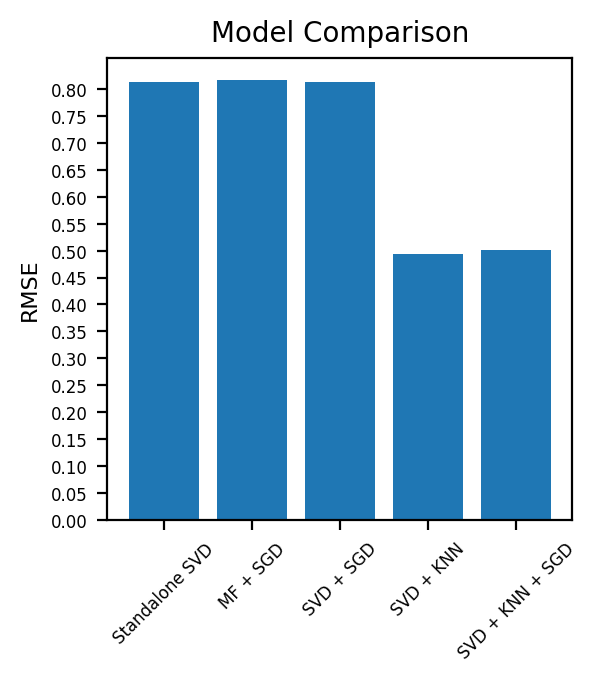

In [64]:
plot_bar_chart_2(model_names, model_rmses, 1, 'RMSE', 'All_Models')

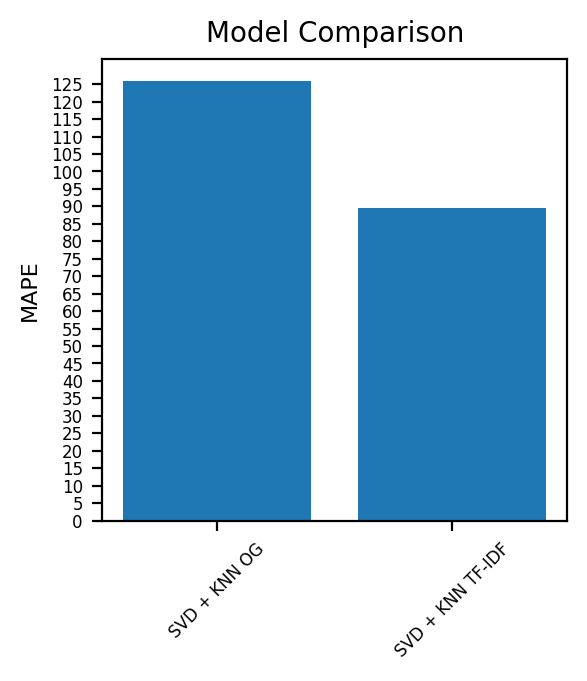

In [65]:
plot_bar_chart_2(best_model_names, best_model_mapes, 100, 'MAPE', 'Best_Models')

## Making recommendations

## Loading movie titles dataframe

In [66]:
titles = pd.read_csv('movie_titles.csv', header = None, names = ['ID', 'Year', 'MainTitle', 'SubTitle'],
            usecols = ['ID', 'Year', 'MainTitle', 'SubTitle'], encoding = 'latin1')

titles.head()

,ID,Year,MainTitle,SubTitle
0,1,2003.0,Dinosaur Planet,NaN
1,2,2004.0,Isle of Man TT 2004 Review,NaN
2,3,1997.0,Character,NaN
3,4,1994.0,Paula Abdul's Get Up & Dance,NaN
4,5,2004.0,The Rise and Fall of ECW,NaN


## Keeping only desired columns

In [67]:
# Replacing NaNs so that columns can be concatenated
titles.fillna('', inplace = True)

# Concatenating columns
titles['Title'] = titles['MainTitle'] + titles['SubTitle']

# Keeping only desired columns
titles = titles[['ID', 'Title']]

titles.head()

,ID,Title
0,1,Dinosaur Planet
1,2,Isle of Man TT 2004 Review
2,3,Character
3,4,Paula Abdul's Get Up & Dance
4,5,The Rise and Fall of ECW


## Creating function to print recommendations for a given user ID

In [68]:
def recommender(data_df, titles_df, user_id, num_recommendations):

    # 250 is the user index (not the user ID, but a user ID's position in the matrix)
    # [::-1] reverses the matrix so that we can get descending sorting
    # 5 is the number of recommendations required
    recommended_ids = np.argsort(data_df[:, user_id])[::-1][:num_recommendations]

    # Retrieving movies' names
    recommended_titles = titles_df[titles_df['ID'].isin(recommended_ids)]

    print('=' * 50)
    print('')
    print(f'{num_recommendations} titles recommended for user ID number {user_id}')
    print('')
    
    for title in recommended_titles['Title']:

        print(title)
        
    print('')
    print('=' * 50)


## Calling function to see recommendations

In [69]:
recommender(tfidf_knn_predicted_ratings, titles, 125, 7)


7 titles recommended for user ID number 125

Neil Diamond: Greatest Hits Live
Chump Change
The Bonesetter
Plain Dirty
One Last Dance
Cartoon Network Halloween: 9 Creepy Cartoon Capers
The Carol Burnett Show: Show Stoppers



## Conclusions
#### In this exercise, SGD did not seem to improve accuracy of most of the models, but it did work well with matrix factorization, yielding a root mean squared error (RMSE) of about 0.81. SVD performed well as a predictor, also at an RMSE of about 0.81. Both of these models are already comparable to Netflix’s 0.85 RMSE, but KNN off of a data matrix reduced by SVD managed to result in a remarkably low RMSE of about 0.49. The results achieved were satisfactory, but improved via TF-IDF. Using the best model (consisting of SVD for dimensionality reduction and KNN for prediction) on a TF-IDF matrix, the mean absolute percentage error (MAPE) went from about 126% to approximately 89%. RMSE was used throughout the entire project, but MAPE was a necessary error metric to evaluate the model’s performance on the TF-IDF matrix, seeing that it was on a much different scale. TF-IDF seems to have significantly improved the best model.